In [1]:
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# Define the file path
# file_path = '../logs/faketime_pause_2-1.log'
file_path = '../logs/faketime_pause.log'

# Read the log file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the log data
data = []
for line in lines:
    if not line.startswith('1'):
        print(f'Skipping line: {line}')
        continue
    parts = line.strip().split(',')
    if len(parts) == 2:
        faked_ts, real_elapsed = parts
        data.append([faked_ts, real_elapsed])

# Create a DataFrame
df = pd.DataFrame(data, columns=['fake', 'real'])

# Display the DataFrame
df.head()

Skipping line: read from config: address = tcp://127.0.0.1:10101, topic = service_discovery/report

Skipping line: Message with delivery token 1 delivered

Skipping line: Process PID: 2823992. Waiting for signal 40 to continue...

Skipping line: Debugger attached. Resume execution...

Skipping line: ddb connector initialized. meta = { pid = 2823992, comm_ip = 2130706433, ipv4_str =127.0.0.1 }



,fake,real
0,1732178671769948,631
1,1732178671770025,706
2,1732178671770100,781
3,1732178671770175,856
4,1732178671770249,930


In [3]:
# normalize the data by substraction the first value
df['fake'] = df['fake'].astype(int) - df['fake'].astype(int).iloc[0]
df['real'] = df['real'].astype(int) - df['real'].astype(int).iloc[0]
df.head()

,fake,real
0,0,0
1,77,75
2,152,150
3,227,225
4,301,299


In [4]:
# find the index where the two consecutive values at real rows are larger than 5000
idx = df[(df['real'].diff() > 500)].index
idx 

Index([13072, 13180, 13298, 13414, 13531, 13648, 13764, 13880, 13997, 14115,
       ...
       98581, 98696, 98806, 98918, 99496, 99498, 99552, 99667, 99779, 99890],
      dtype='int64', length=721)

In [5]:
# # find the index where the two consecutive values at real rows are larger than 5000
# idx = df[(df['real'].diff() > 5000)].index
# idx 

In [6]:
suspend_pt = idx - 1
suspend_pt

Index([13071, 13179, 13297, 13413, 13530, 13647, 13763, 13879, 13996, 14114,
       ...
       98580, 98695, 98805, 98917, 99495, 99497, 99551, 99666, 99778, 99889],
      dtype='int64', length=721)

In [7]:
# get all rows at the index
df.loc[suspend_pt]

,fake,real
13071,979377,979402
13179,991057,999890
13297,1002344,1021474
13413,1013535,1042969
13530,1024678,1064544
...,...,...
99497,8555463,16697968
99551,8562207,16704753
99666,8573597,16724638
99778,8584746,16746007


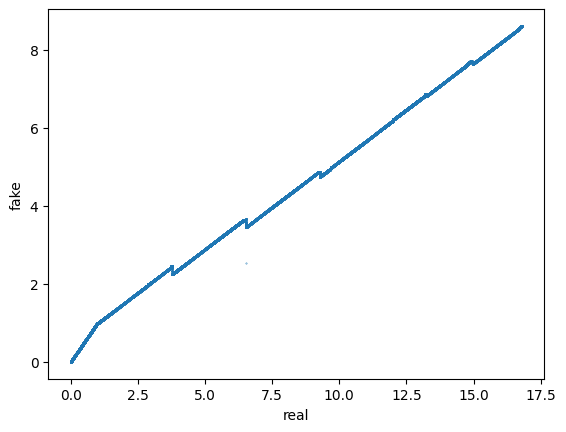

In [8]:
# draw a scatter plot of the df data where the x-axis is the fake column and y-axis is a constant value
# df['constant'] = 1  # Add a constant column for y-axis

df_scaled = df.copy()
df_scaled['real'] = df_scaled['real'] / 1000000
df_scaled['fake'] = df_scaled['fake'] / 1000000

import matplotlib.pyplot as plt

ax = df_scaled.plot.scatter(x='real', y='fake', s=0.1)


# ax.set_xticklabels([ int(n/1000000) for n in range(df['real'].min(), df['real'].max(), 1000000)])
# ax.set_yticklabels([ int(n/1000000) for n in range(df['fake'].min(), df['fake'].max(), 1000000)])
plt.show()

In [9]:
# num_points = 200
num_points = 800

extracted_data = pd.DataFrame()

# for i in idx:
i = idx[1]
offset = 200
start_idx = i - offset
end_idx = min(i + num_points, len(df))
extracted_data = pd.concat([extracted_data, df.iloc[start_idx:end_idx]])

extracted_data["fake"] = extracted_data["fake"] - extracted_data["fake"].iloc[0]
extracted_data["real"] = extracted_data["real"] - extracted_data["real"].iloc[0]
extracted_data.reset_index(drop=True, inplace=True)

extracted_data.head()

,fake,real
0,0,0
1,74,74
2,149,149
3,224,223
4,298,298


In [10]:
pause_idx = extracted_data[(extracted_data['real'].diff() > 500)].index
pause_idx

Index([92, 200, 318, 434, 551, 668, 784, 900], dtype='int64')

In [11]:
df.iloc[idx[0] - 1], df.iloc[idx[0]], df.iloc[idx[0] + 1]

(fake    979377
 real    979402
 Name: 13071, dtype: int64,
 fake    983052
 real    991888
 Name: 13072, dtype: int64,
 fake    983130
 real    991962
 Name: 13073, dtype: int64)

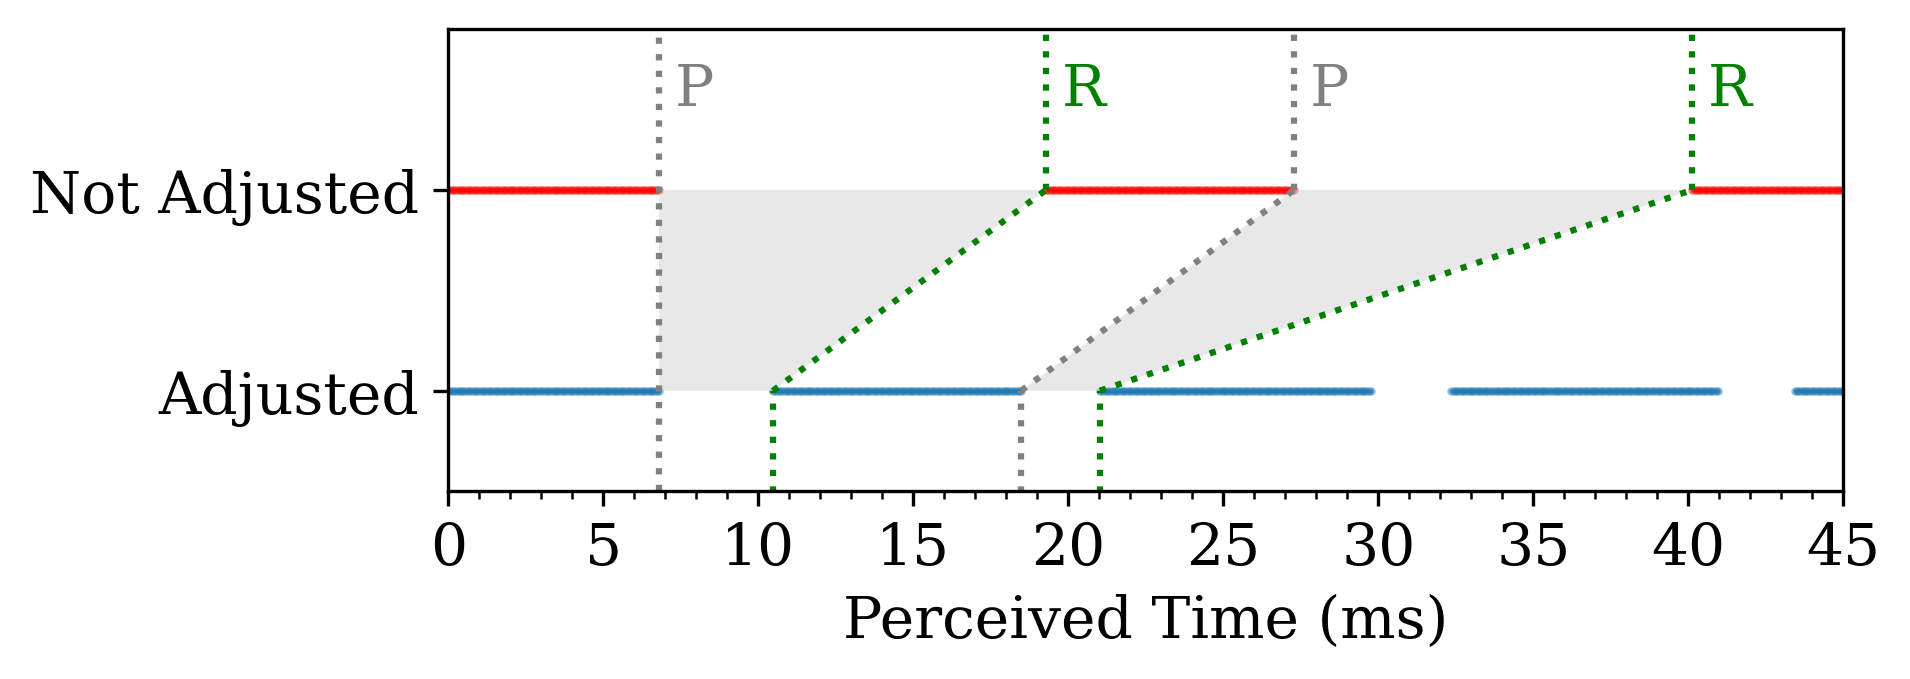

In [12]:
# draw a scatter plot of the df data where the x-axis is the fake column and y-axis is a constant value

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
# plt.rcParams['font.weight'] = 'bold'

extracted_data_scaled = extracted_data.copy()
extracted_data_scaled['constant_fake'] = 1  # Add a constant column for y-axis
extracted_data_scaled['constant_real'] = 2  # Add a constant column for y-axis
# extracted_data_scaled['real'] = extracted_data_scaled['real'] - extracted_data_scaled['real'].iloc[0]
# extracted_data_scaled['fake'] = extracted_data_scaled['fake'] - extracted_data_scaled['fake'].iloc[0]
extracted_data_scaled['real'] = extracted_data_scaled['real'] / 1000
extracted_data_scaled['fake'] = extracted_data_scaled['fake'] / 1000

import matplotlib.pyplot as plt
import numpy as np

lw = 1.5

ax = extracted_data_scaled.plot.scatter(x='fake', y='constant_fake', s=1, alpha=0.5)
ax = extracted_data_scaled.plot.scatter(x='real', y='constant_real', s=1, ax=ax, color='red', alpha=0.5)
# ax = extracted_data_scaled.plot.scatter(x='real', y='constant_real', s=0.01)
ax.set_ylim(0.5, 2.8)
ax.set_xlim(0, 45)

ax.yaxis.set_ticks([])
ax.set_ylabel('')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Adjusted', 'Not Adjusted'])

ax.set_xlabel('Perceived Time (ms)')

# 1st pause
idx1_start = pause_idx[0] - 1
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx1_start], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx1_start] + 0.5, 2.5, 'P', verticalalignment='center', color='gray')

idx1_end = pause_idx[0]
ax.plot([extracted_data_scaled['fake'].iloc[idx1_end], extracted_data_scaled['fake'].iloc[idx1_end]], 
    [0, 1], color='green', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['fake'].iloc[idx1_end], extracted_data_scaled['real'].iloc[idx1_end]], 
    [1, 2], color='green', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['real'].iloc[idx1_end], extracted_data_scaled['real'].iloc[idx1_end]], 
    [2, 3.5], color='green', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['real'].iloc[idx1_end] + 0.5, 2.5, 'R', verticalalignment='center', color='green')

poly_x = [extracted_data_scaled['fake'].iloc[idx1_start], extracted_data_scaled['fake'].iloc[idx1_end], extracted_data_scaled['real'].iloc[idx1_end], extracted_data_scaled['real'].iloc[idx1_start]]
poly_y = [1, 1, 2, 2]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)
# ax.fill_betweenx([1, 2], extracted_data_scaled['fake'].iloc[idx1_start], extracted_data_scaled['real'].iloc[idx1_end], color='gray', alpha=0.3)

# 2nd pause
idx2_start = pause_idx[1] - 1
ax.plot([extracted_data_scaled['fake'].iloc[idx2_start], extracted_data_scaled['fake'].iloc[idx2_start]], 
    [0, 1], color='gray', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['fake'].iloc[idx2_start], extracted_data_scaled['real'].iloc[idx2_start]], 
    [1, 2], color='gray', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['real'].iloc[idx2_start], extracted_data_scaled['real'].iloc[idx2_start]], 
    [2, 3.5], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['real'].iloc[idx2_start] + 0.5, 2.5, 'P', verticalalignment='center', color='gray')

idx2_end = pause_idx[1]
ax.plot([extracted_data_scaled['fake'].iloc[idx2_end], extracted_data_scaled['fake'].iloc[idx2_end]], 
    [0, 1], color='green', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['fake'].iloc[idx2_end], extracted_data_scaled['real'].iloc[idx2_end]], 
    [1, 2], color='green', linestyle=':', linewidth=lw)
ax.plot([extracted_data_scaled['real'].iloc[idx2_end], extracted_data_scaled['real'].iloc[idx2_end]], 
    [2, 3.5], color='green', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['real'].iloc[idx2_end] + 0.5, 2.5, 'R', verticalalignment='center', color='green')

poly_x = [extracted_data_scaled['fake'].iloc[idx2_start], extracted_data_scaled['fake'].iloc[idx2_end], extracted_data_scaled['real'].iloc[idx2_end], extracted_data_scaled['real'].iloc[idx2_start]]
poly_y = [1, 1, 2, 2]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(6, 2)
plt.show()

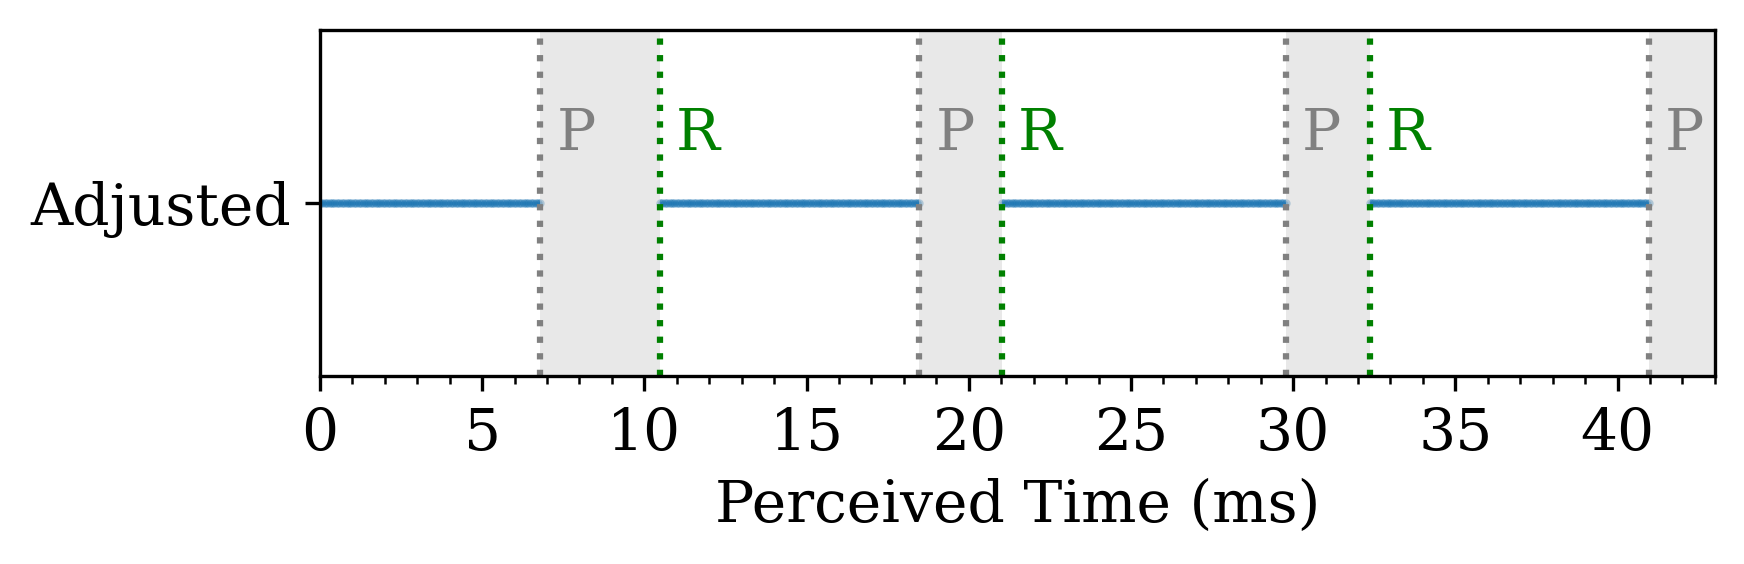

In [14]:
# draw a scatter plot of the df data where the x-axis is the fake column and y-axis is a constant value

plt.rcParams['font.size'] = 14

extracted_data_scaled = extracted_data.copy()
extracted_data_scaled['constant_fake'] = 1  # Add a constant column for y-axis
extracted_data_scaled['constant_real'] = 2  # Add a constant column for y-axis
# extracted_data_scaled['real'] = extracted_data_scaled['real'] - extracted_data_scaled['real'].iloc[0]
# extracted_data_scaled['fake'] = extracted_data_scaled['fake'] - extracted_data_scaled['fake'].iloc[0]
extracted_data_scaled['real'] = extracted_data_scaled['real'] / 1000
extracted_data_scaled['fake'] = extracted_data_scaled['fake'] / 1000

import matplotlib.pyplot as plt
import numpy as np

lw = 1.5

ax = extracted_data_scaled.plot.scatter(x='fake', y='constant_fake', s=1, alpha=0.5)
ax.set_ylim(0.5, 1.5)
ax.set_xlim(0, 43)

ax.yaxis.set_ticks([])
ax.set_ylabel('')
ax.set_yticks([1])
ax.set_yticklabels(['Adjusted'])

ax.set_xlabel('Perceived Time (ms)')

# 1st pause
idx1_start = pause_idx[0] - 1
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx1_start], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx1_start] + 0.5, 1.2, 'P', verticalalignment='center', color='gray')

idx1_end = pause_idx[0]
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx1_end], color='green', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx1_end] + 0.5, 1.2, 'R', verticalalignment='center', color='green')

# fill the area between the two vertical lines with gray color
poly_x = [extracted_data_scaled['fake'].iloc[idx1_start], extracted_data_scaled['fake'].iloc[idx1_end], extracted_data_scaled['fake'].iloc[idx1_end], extracted_data_scaled['fake'].iloc[idx1_start]]
poly_y = [0.5, 0.5, 1.5, 1.5]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)


# 2nd pause
idx2_start = pause_idx[1] - 1
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx2_start], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx2_start] + 0.5, 1.2, 'P', verticalalignment='center', color='gray')

idx2_end = pause_idx[1]
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx2_end], color='green', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx2_end] + 0.5, 1.2, 'R', verticalalignment='center', color='green')

poly_x = [extracted_data_scaled['fake'].iloc[idx2_start], extracted_data_scaled['fake'].iloc[idx2_end], extracted_data_scaled['fake'].iloc[idx2_end], extracted_data_scaled['fake'].iloc[idx2_start]]
poly_y = [0.5, 0.5, 1.5, 1.5]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)

# 3rd pause
idx3_start = pause_idx[2] - 1
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx3_start], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx3_start] + 0.5, 1.2, 'P', verticalalignment='center', color='gray')

idx3_end = pause_idx[2]
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx3_end], color='green', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx3_end] + 0.5, 1.2, 'R', verticalalignment='center', color='green')

poly_x = [extracted_data_scaled['fake'].iloc[idx3_start], extracted_data_scaled['fake'].iloc[idx3_end], extracted_data_scaled['fake'].iloc[idx3_end], extracted_data_scaled['fake'].iloc[idx3_start]]
poly_y = [0.5, 0.5, 1.5, 1.5]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)

# 4th pause
idx4_start = pause_idx[3] - 1
ax.axvline(x=extracted_data_scaled['fake'].iloc[idx4_start], color='gray', linestyle=':', linewidth=lw)
ax.text(extracted_data_scaled['fake'].iloc[idx4_start] + 0.5, 1.2, 'P', verticalalignment='center', color='gray')

idx4_end = pause_idx[3]
# ax.axvline(x=extracted_data_scaled['fake'].iloc[idx4_end], color='green', linestyle=':', linewidth=lw)
# ax.text(extracted_data_scaled['fake'].iloc[idx4_end] + 0.5, 1.2, 'R', verticalalignment='center', color='green')

poly_x = [extracted_data_scaled['fake'].iloc[idx4_start], extracted_data_scaled['fake'].iloc[idx4_end], extracted_data_scaled['fake'].iloc[idx4_end], extracted_data_scaled['fake'].iloc[idx4_start]]
poly_y = [0.5, 0.5, 1.5, 1.5]
plt.fill(poly_x, poly_y, color='lightgray', edgecolor='none', alpha=0.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(6, 1.5)
plt.show()